# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from sklearn.metrics import f1_score

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
# To create the user-item matrix, we only need the email=user id and item=article_id
user_items = df[['email', 'article_id']]
user_items.head()

,email,article_id
0,ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,1430.0
1,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b,1314.0
2,b96a4f2e92d8572034b1e9b28f9ac673765cd074,1429.0
3,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7,1338.0
4,f01220c46fc92c6e6b161b1849de11faacd7ccb2,1276.0


In [4]:
# insepct nan values
user_items[user_items.email.isnull() == True]

,email,article_id
25131,NaN,1016.0
29758,NaN,1393.0
29759,NaN,20.0
29760,NaN,1174.0
29761,NaN,62.0
35264,NaN,224.0
35276,NaN,961.0
35277,NaN,268.0
35278,NaN,268.0
35279,NaN,268.0


In [5]:
user_distribution = user_items.groupby(['email']).count()

In [6]:
user_distribution.head()

,article_id
email,
0000b6387a0366322d7fbfc6434af145adf7fed1,13
001055fc0bb67f71e8fa17002342b256a30254cd,4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3
001a852ecbd6cc12ab77a785efa137b2646505fe,6
001fc95b90da5c3cb12c501d201a915e4f093290,2


In [7]:
user_distribution.describe()

,article_id
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


In [8]:
# Fill in the median and maximum number of user_article interactios below
median_val = user_distribution.median()[0] # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = user_distribution.max()[0] # The maximum number of user-article interactions by any 1 user is ______.

In [9]:
print("50% of individuals interact with {} number of articles or fewer.".format(median_val))
print("The maximum number of user-article interactions by any 1 user is {}.".format(max_views_by_user))

50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


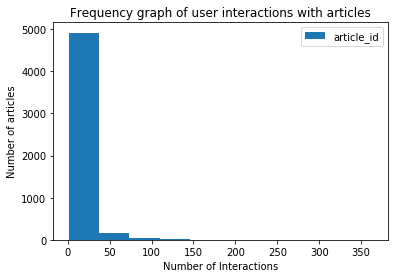

In [10]:
ax = user_distribution.plot(kind='hist', title='Frequency graph of user interactions with articles')
ax.set_xlabel("Number of Interactions")
ax.set_ylabel("Number of articles");

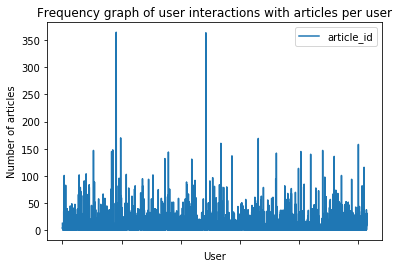

In [11]:
ax = user_distribution.plot(title='Frequency graph of user interactions with articles per user')
ax.set_xlabel("User")
ax.set_ylabel("Number of articles");

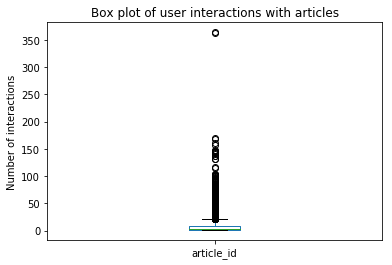

In [12]:
ax = user_distribution.plot(kind='box', title='Box plot of user interactions with articles')
ax.set_ylabel("Number of interactions");

In [13]:
distribution_75 = user_distribution[user_distribution.article_id < 9 ] #75%	9.000000

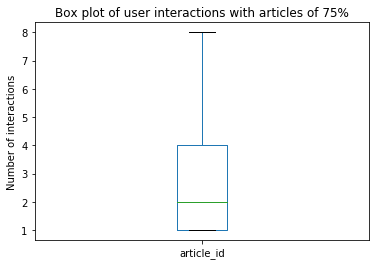

In [14]:
ax = distribution_75.plot(kind='box', title='Box plot of user interactions with articles of 75%')
ax.set_ylabel("Number of interactions");

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [15]:
# Find and explore duplicate articles
sum(df_content['article_id'].duplicated())

5

In [16]:
# show duplicates
df_content[df_content.duplicated(['article_id'])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [17]:
# Remove any rows that have the same article_id - only keep the first
df_content['article_id'].drop_duplicates(inplace=True)

In [18]:
# verify
sum(df_content['article_id'].duplicated())

0

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [19]:
df.shape, df_content.shape

((45993, 3), (1056, 5))

In [20]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique() # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

In [21]:
print("a. The number of unique articles that have an interaction with a user is {}.".format(unique_articles))
print("b. The number of unique articles in the dataset (whether they have any interactions or not) is {}.".format(total_articles))
print("c. The number of unique users in the dataset. (excluding null values) is {}.".format(unique_users))
print("d. The number of user-article interactions in the dataset is {}.".format(user_article_interactions))

a. The number of unique articles that have an interaction with a user is 714.
b. The number of unique articles in the dataset (whether they have any interactions or not) is 1051.
c. The number of unique users in the dataset. (excluding null values) is 5148.
d. The number of user-article interactions in the dataset is 45993.


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [22]:
article_distribution = user_items.groupby(['article_id']).count()

In [23]:
article_distribution.head()

,email
article_id,
0.0,14
2.0,58
4.0,13
8.0,85
9.0,10


In [24]:
article_distribution.describe()

,email
count,714.000000
mean,64.392157
std,109.161462
min,1.000000
25%,8.000000
50%,25.000000
75%,69.000000
max,937.000000


In [25]:
article_distribution[article_distribution.email == article_distribution.max()[0]]

,email
article_id,
1429.0,937


In [26]:
most_viewed_article_id = "1429.0" # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [27]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [28]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [29]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    top_articles = get_top_article_ids(n, df=df)

    titles = []
    for i, item in enumerate(top_articles):
        titles.append(df[df.article_id == top_articles[i]].title.values[0])
    
    top_articles = titles
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
        
    user_items = df[['user_id', 'article_id']]
    article_distribution = user_items.groupby(['article_id']).count()
    top_articles = list(article_distribution.sort_values('user_id', ascending=False).iloc[:n].index.values)
     
    return top_articles # Return the top article ids

In [30]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [31]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [32]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    user_item = df.drop_duplicates().groupby(['user_id', 'article_id']).size().unstack(fill_value=0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [33]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [34]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    dot_prod = user_item.iloc[user_id-1:user_id].dot(np.transpose(user_item))

    # sort by similarity
    dot_prod = dot_prod.sort_values(by=user_id, axis=1, ascending=False)
   
    # remove the own user's id
    dot_prod.drop([user_id], axis=1, inplace=True)
    
    # create list of just the ids
    most_similar_users = list(dot_prod)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [35]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [36]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []
    
    for item in article_ids:
        article_names.append(df[df.article_id == float(item)].title.values[0])
            
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    user_df = user_item.iloc[user_id-1:user_id].sort_values(by=user_id, axis=1, ascending=False)

    seen_items = user_df[(user_df == 1)]
    seen_items.dropna(inplace=True, axis=1)
    seen_items = list(seen_items)
    
    article_ids = []
    article_names = []
    for item in seen_items:
        article_ids.append(str(item))
        article_names.append(df[df.article_id == item].title.values[0])
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    recs = []
    for sim_user in find_similar_users(user_id):
            recs += list(set(get_user_articles(sim_user)[0]) - set(get_user_articles(user_id)[0]))
            if len(recs) > m:
                break

    recs = recs[:m]
    return recs # return your recommendations for this user_id    

In [37]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['awesome deep learning papers',
 'using brunel in ipython/jupyter notebooks',
 'optimizing a marketing campaign: moving from predictions to actions',
 'insights from new york car accident reports',
 'the unit commitment problem',
 'markdown for jupyter notebooks cheatsheet',
 'discover hidden facebook usage insights',
 'twelve\xa0ways to color a map of africa using brunel',
 'shaping data with ibm data refinery',
 'maximize oil company profits']

In [38]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [39]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    num_interactions = []
    similarity = []
    neighbor_ids = []

    for sim_user in find_similar_users(user_id):
        num_interactions.append(user_item.iloc[user_id-1:user_id].sum(axis=1).values[0])
        neighbor_ids.append(sim_user)
        similarity.append(user_item[user_item.index == user_id].dot(user_item.loc[sim_user].T).values[0])

    neighbors_df = pd.DataFrame(list(zip(neighbor_ids, similarity, num_interactions)), columns = ['neighbor_id', 'similarity', 'num_interactions'])
    neighbors_df = neighbors_df.sort_values(['similarity', 'neighbor_id'], ascending=[False, True])

    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = []
    
    # choose the users that have the most total article interaction
    neighbors_df = get_top_sorted_users(user_id)
    seen = get_user_articles(user_id)[0]
    for index, row in neighbors_df.iterrows():
        sim_user = row['neighbor_id']
        recs_sim_user = get_user_articles(sim_user)[0]    
        recs += [x for x in recs_sim_user if x not in seen]
        if len(recs) > m:
            break

    # choose articles with the articles with the most total interactions
    top_articles = get_top_article_ids(714) # means all
    top_articles_dict = {} # shows position in top articles
    for item in list(set(recs[:m])): # remove duplicates
        top_articles_dict[item] = top_articles.index(float(item))
    top_articles_dict = {k: v for k, v in sorted(top_articles_dict.items(), key=lambda item: item[1])}
    recs = top_articles_dict.keys()
    
    rec_names = get_article_names(recs)
        
    return recs, rec_names

In [40]:
# verify the order by top_articles index (the lower the better)
rec_ids, _ = user_user_recs_part2(20, 10)
top_articles = get_top_article_ids(714) # means all

for item in rec_ids:
    print(item, top_articles.index(float(item)))

1364.0 4
1351.0 14
1400.0 33
164.0 40
213.0 112
379.0 173
1366.0 177
967.0 253
225.0 322
1397.0 363


In [41]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
dict_keys(['1364.0', '1351.0', '1400.0', '164.0', '213.0', '379.0', '1366.0', '967.0', '225.0', '1397.0'])

The top 10 recommendations for user 20 are the following article names:
['predicting churn with the spss random tree algorithm', 'model bike sharing data with spss', 'uci ml repository: chronic kidney disease data set', 'learn tensorflow and deep learning together and now!', 'modeling energy usage in new york city', 'data structures related to machine learning algorithms', 'process events from the watson iot platform in a streams python application', 'ml algorithm != learning machine', 'a visual explanation of the back propagation algorithm for neural networks', 'total employment, by economic activity (thousands)']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [42]:
get_top_sorted_users(1).iloc[0].neighbor_id, get_top_sorted_users(131).iloc[9].neighbor_id

(3933, 242)

In [43]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1).iloc[0].neighbor_id # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9].neighbor_id # Find the 10th most similar user to user 131

In [44]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

*We are only able to make recommendatins using the rank based recommendations. This functions should work fine for new users. The Collaborative Filtering function has no data to provide a recommendation to a new user, this is known as the "Cold Start Problem". 
A better method would be use a mix of Rank based Collaborative Filtering and Content Based Collaborative Filtering for new user because we would have a higher chance to really meet the taste of the new user instead of the general taste.*

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [45]:
new_user = '0.0'
new_user_recs = []

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

new_user_recs_as_float = get_top_article_ids(10) # Your recommendations here
for item in new_user_recs_as_float:
    new_user_recs.append(str(item))

In [46]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [49]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [50]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [51]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

**Provide your response here.**

*SVD can achieve a very good result on data with no missing values. In contrast to the lesson, we have no missing data. That is the reason why SVD works really well in this case and we don't need to switch to FunkSVD.
(https://medium.com/datadriveninvestor/how-funk-singular-value-decomposition-algorithm-work-in-recommendation-engines-36f2fbf62cac)*

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

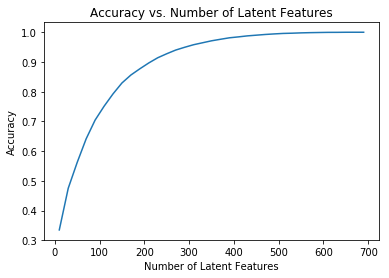

In [52]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [53]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    user_item_test = user_item_test.loc[list(set(test_idx) & set(user_item_train.index)), list(set(test_arts) & set(user_item_train.columns))]
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

# additional defs for training data
train_idx = user_item_train.index
train_arts = user_item_train.columns

In [54]:
df_train.shape, df_test.shape

((40000, 3), (5993, 3))

In [55]:
# how many users/items can we make predictions for?
len(set(test_idx) & set(train_idx)), len(set(test_arts) & set(train_arts))

(20, 574)

In [56]:
# how many users/items are we not able to we make predictions for because of the cold start problem?
len(set(test_idx) - set(train_idx)), len(set(test_arts) - set(train_arts))

(662, 0)

In [57]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [58]:
# for better changing threshold, we define the svd as a function

def svd(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    sum_errs_train - errors of train data set
    sum_errs_test - error of test data set
    f1_score_train - f1 score of training data set
    f1_score_test - f1 score of test data set
    num_latent_feats - number of latent features
    
    '''
    user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)
    # additional defs for training data
    train_idx = user_item_train.index
    train_arts = user_item_train.columns
    
    # fit SVD on the user_item_train matrix
    u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below
    
    # test data
    idx = train_idx.isin(test_idx)
    arts = train_arts.isin(test_arts)
    u_test = u_train[idx, :]
    vt_test = vt_train[:, arts]

    # Use these cells to see how well you can use the training 
    # decomposition to predict on test data
    num_latent_feats = np.arange(10,700+10,20)
    sum_errs_test = []
    sum_errs_train = []
    sum_errs_all = []
    f1_score_train = []
    f1_score_test = []
    
    for k in num_latent_feats:
        # restructure with k latent features

        s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
        u_new_test, vt_new_test = u_test[:, :k], vt_test[:k, :]

        # dot product:
        user_item_est_train = np.around(np.dot(np.dot(u_new, s_new), vt_new))
        user_item_est_test = np.around(np.dot(np.dot(u_new_test, s_new), vt_new_test))

        # Calculate the error of each prediction with the true value
        diffs_train = np.subtract(user_item_train, user_item_est_train)
        diffs_test = np.subtract(user_item_test, user_item_est_test)

        # Total Error
        err_train = np.sum(np.sum(np.abs(diffs_train)))
        err_test = np.sum(np.sum(np.abs(diffs_test)))

        # append error list
        sum_errs_train.append(err_train)
        sum_errs_test.append(err_test)
        
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
        f1_score_train.append(f1_score(np.array(user_item_train).flatten(), user_item_est_train.flatten(), labels=[1.0], average='macro'))
        f1_score_test.append(f1_score(np.array(user_item_test).flatten(), user_item_est_test.flatten(), labels=[1.0], average='macro'))

    return user_item_train ,user_item_test, sum_errs_train, sum_errs_test, f1_score_train, f1_score_test, num_latent_feats

user_item_train ,user_item_test, sum_errs_train, sum_errs_test, f1_score_train, f1_score_test, num_latent_feats = svd(df_train, df_test)

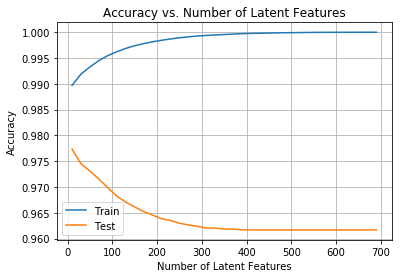

In [59]:
def plot_accuracy(num_latent_feats, user_item_train ,user_item_test, sum_errs_train, sum_errs_test):
    '''
    INPUT:
    num_latent_feats - number of latent features
    df_test - test dataframe
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    sum_errs_train - errors of train data set
    sum_errs_test - error of test data set
    
    
    '''
    plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0] * user_item_test.shape[1]), label='Train')
    plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test.shape[0] * user_item_test.shape[1]), label='Test')
    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy');
    plt.title('Accuracy vs. Number of Latent Features')
    plt.grid()
    plt.legend();
    
plot_accuracy(num_latent_feats, user_item_train ,user_item_test, sum_errs_train, sum_errs_test)

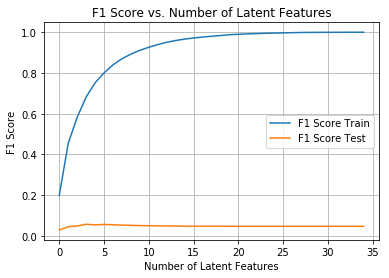

In [60]:
def plot_f1_score(f1_score_train,f1_score_test):
    '''
    INPUT:
    f1_score_train - f1 score of training data set
    f1_score_test - f1 score of test data set
    
    '''
    plt.plot(f1_score_train, label='F1 Score Train')
    plt.plot(f1_score_test, label='F1 Score Test')
    plt.xlabel('Number of Latent Features');
    plt.ylabel('F1 Score');
    plt.title('F1 Score vs. Number of Latent Features')
    plt.grid()
    plt.legend();
                  
plot_f1_score(f1_score_train,f1_score_test)

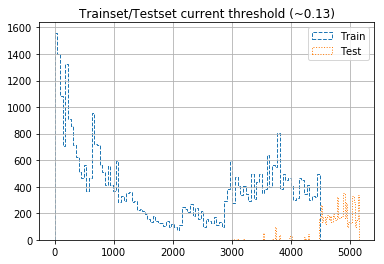

In [61]:
def plot_threshold(df_test, df_train, title):
    
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    '''
    plt.hist(df_train.user_id, bins = 100, histtype='step', linestyle='--',label='Train')
    plt.hist(df_test.user_id, bins = 100, histtype='step', linestyle=':',label='Test')
    plt.legend()
    plt.title(title)
    plt.grid()
    plt.show();
    # https://stackoverflow.com/questions/43562301/plotting-multiple-histograms-using-different-line-styles-python

plot_threshold(df_test, df_train, 'Trainset/Testset current threshold (~0.13)')

*Lets' try to change the treshold to 0.5*

In [62]:
np.round(df.shape[0]/2, 0)

22996.0

In [63]:
# threshold 0.5
df_train = df.head(22996)
df_test = df.tail(22996)
df_train.shape, df_test.shape

((22996, 3), (22996, 3))

In [64]:
user_item_train ,user_item_test, sum_errs_train, sum_errs_test, f1_score_train, f1_score_test, num_latent_feats = svd(df_train, df_test)

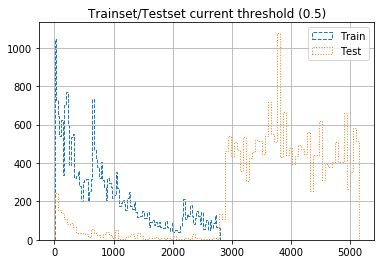

In [65]:
plot_threshold(df_test, df_train, 'Trainset/Testset current threshold (0.5)')

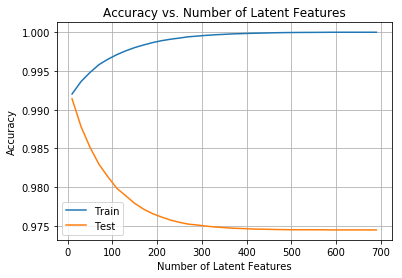

In [66]:
plot_accuracy(num_latent_feats, user_item_train ,user_item_test, sum_errs_train, sum_errs_test)

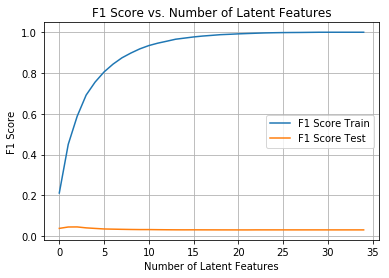

In [67]:
plot_f1_score(f1_score_train,f1_score_test)

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

**Comment & Disussion**

*The accuracy of the test data drops on every latent feature while the accuracy of the training data increases.
A reason might be the few interactions which the test and the training data have in common. Te accuracy is not a good metric for measuring the quality of our recommendations as it tends to overfit the data. We tried another metric:
the f1 score which converges at around 35 latent features.* 


*We showed that the quality of our model can be changed by using different thresholds. We have already seen two different ones: 0.13 and 0.5. We could try some more. We are able to evaluate them by several distinct metrics (accuracy/f1/precision/recall) to find th turning point where the metrics satures and the model does not overfit. Based on the results we have already seen, we assume that the model converges between around 35 features because the f1 score increases and the accuracy (on the test data set) don't drop too fast. The accuracy is more dependent on the the threshold than the f1 score. But the f1 performs poorly on the test data set, an indicator that our model is not working well in practice.*

**Next steps**

*A method by which we could test how well our recommendation engine is working in practice could be according to the data we have*
* *using like/dislike (=heart) to evaluate how much the user likes the recommendation*
* *using pinned/not pinned (=pin sign) to evaluate how much the user likes the recommendation*
* *using click/read or not clicked/not read  to evaluate how much the user likes the recommendation*
* *using a system which combines alle the three steps above*

**Submit**

In [2]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0